In [68]:
# hb noise case
# param_path = '/home/lpancotto/code/tesis/adjoint/pySPEC/examples/adjoint_lbfgs_DG_hb_noise-scaled'
# pinn_path = '/home/lpancotto/code/tesis/pinns/1d_tests/adjoint-comparation/fixed-buoys/DGpinn_hb_noise-scaled-2'+'/'+ 't220'

# uh noise case
# param_path = '/home/lpancotto/code/tesis/adjoint/pySPEC/examples/adjoint_lbfgs_DG_uh_noise-scaled'
# pinn_path = '/home/lpancotto/code/tesis/pinns/1d_tests/adjoint-comparation/fixed-buoys/DGpinn_uh_noise-scaled-2'+'/'+ 't240'

# straight case
param_path = '/home/lpancotto/code/tesis/adjoint/pySPEC/examples/adjoint_lbfgs_DG-scaled'
pinn_path = '/home/lpancotto/code/tesis/pinns/1d_tests/adjoint-comparation/fixed-buoys/DGpinn-scaled-alpha'+'/'+ 't210'


In [69]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace

import pySPEC as ps
from pySPEC.time_marching import SWHD_1D, Adjoint_SWHD_1D



# Parse JSON into an object with attributes corresponding to dict keys.
fpm = json.load(open(f'{param_path}/params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
fpm.Lx = 2*np.pi*fpm.Lx
fpm.out_path = fpm.forward_out_path
fpm.ostep = fpm.forward_ostep
# Parse JSON into an object with attributes corresponding to dict keys.
bpm = json.load(open(f'{param_path}/params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
bpm.Lx = 2*np.pi*bpm.Lx
bpm.out_path = bpm.backward_out_path
bpm.ostep = bpm.backward_ostep
grid   = ps.Grid1D(fpm)
xx = grid.xx

sns.set_style("white")
# palette = sns.color_palette("mako", as_cmap=True)
sns.set_palette(palette='Dark2')


In [70]:
uu =  np.load(f'{fpm.field_path}/uu_memmap.npy', mmap_mode='r')  # all t uu
hh =  np.load(f'{fpm.field_path}/hh_memmap.npy', mmap_mode='r')  # all t hh
hbs =  np.load(f'{bpm.hb_path}/hb_memmap.npy', mmap_mode='r')  # all iit hb



loss = np.loadtxt(f'{fpm.hb_path}/loss.dat', unpack=True)
val = np.loadtxt(f'{fpm.hb_path}/hb_val.dat' , unpack=True)

last_iit = int(loss[0][-1]) -1
hb = hbs[last_iit] # the last prediction
print('last iit  '  , last_iit)

true_uu =  np.load(f'{fpm.data_path}/uu_memmap.npy', mmap_mode='r')  # all t true_uu
true_hh =  np.load(f'{fpm.data_path}/hh_memmap.npy', mmap_mode='r')  # all t true_hh
true_hb = np.load(f'{bpm.data_path}/hb.npy') # true hb

val_step = 80*250
ref = [true_uu[val_step],true_hh[val_step],true_hb]
adj = [uu[val_step],hh[val_step],hb]
N = len(ref[0])
domain = np.linspace(0,2*np.pi, N)

# pinn results

pinn = np.load(f'{pinn_path}/predicted.npy')


last iit   80


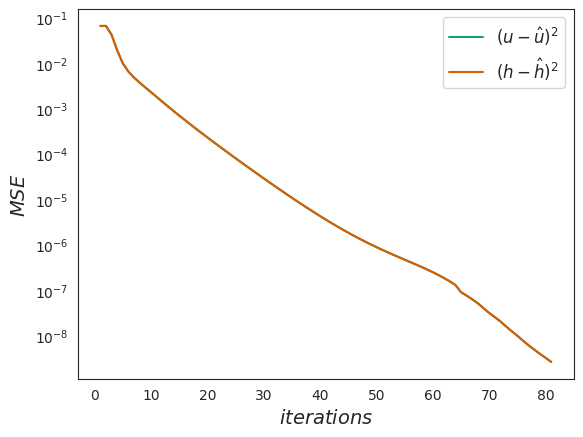

In [71]:
plt.figure(0 )
plt.semilogy(loss[0], loss[1] , label = '$(u-\hat{u})^2$'   )
plt.semilogy(loss[0], loss[2] , label = '$(h- \hat{h})^2$'  )
plt.xlabel('$iterations$' , fontsize=14)
plt.ylabel('$MSE$' , fontsize=14)
plt.legend(fontsize=12)
plt.savefig(f'{param_path}/loss')


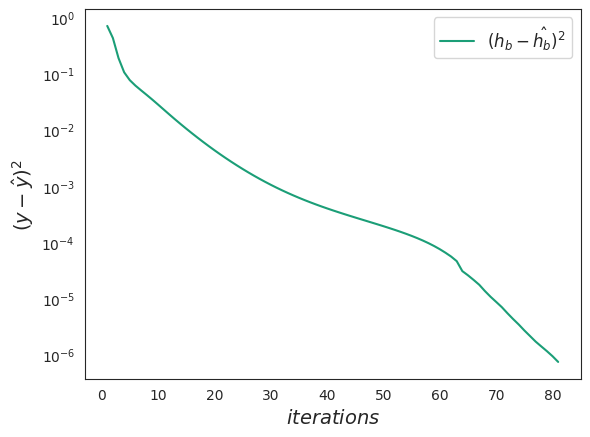

In [72]:
plt.figure(3)
# plt.semilogy(val[0] , val[1] , label = '$MRSE(u - \hat{u})$' )
# plt.semilogy(val[0] , val[2] , label = '$MRSE(h - \hat{h})$')
plt.semilogy(val[0] , val[-1] , label = '$(h_b - \hat{h_b})^2$' )
plt.xlabel('$iterations$', fontsize=14)
plt.ylabel('$(y - \hat{y})^2$', fontsize=14)
plt.legend( fontsize=12)
plt.savefig(f'{param_path}/validation')


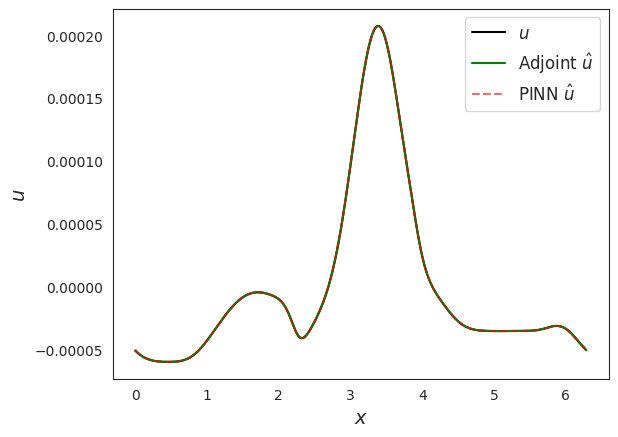

In [73]:
plt.figure(1)
plt.ylabel('$u$' , fontsize=14)
plt.xlabel('$x$' , fontsize=14)
plt.plot(domain,ref[0] , color = 'black' , label = '$u$', alpha = 1)
plt.plot(domain, adj[0] , label = 'Adjoint $\hat{u}$'  , color = 'green')
plt.plot(domain, pinn[0] , label = 'PINN $\hat{u}$', alpha = 0.6  , color = 'red', linestyle = '--')
plt.ylabel('$u$' , fontsize=14)
plt.xlabel('$x$' , fontsize=14)
plt.legend( fontsize=12)
plt.savefig(f'{param_path}/vx')


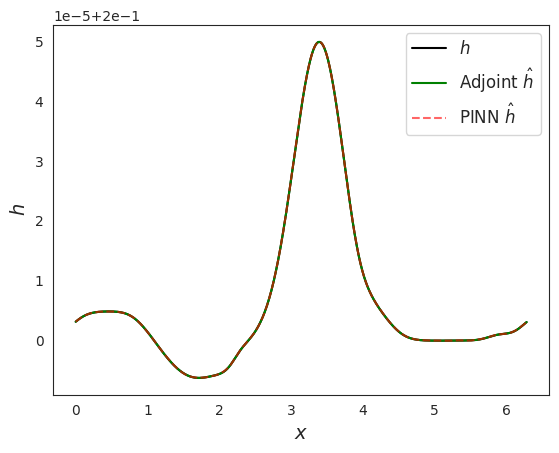

In [74]:
plt.figure(2)
plt.plot(domain,ref[1] , color = 'black' , label = '$h$', alpha = 1)
plt.plot(domain, adj[1] , label = 'Adjoint $\hat{h}$'  , color = 'green')
plt.plot(domain, pinn[1] , label = 'PINN $\hat{h}$', alpha = 0.6  , color = 'red', linestyle = '--')

plt.ylabel('$h$' , fontsize=14)
plt.xlabel('$x$' , fontsize=14)
plt.legend(fontsize=12)

plt.savefig(f'{param_path}/th')


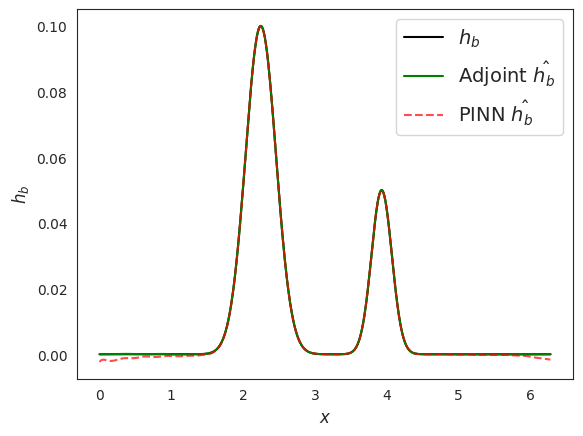

In [75]:
plt.figure(4)
plt.plot(domain,ref[-1] , color = 'black' , label = '$h_b$', alpha = 1)
plt.plot(domain, adj[-1] , label = 'Adjoint $\hat{h_b}$'  , color = 'green')
plt.plot(domain, pinn[-1] , label = 'PINN $\hat{h_b}$', alpha = 0.7  , color = 'red', linestyle = '--')
plt.ylabel('$h_b$', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.legend(fontsize=14)
plt.savefig(f'{param_path}/fs')


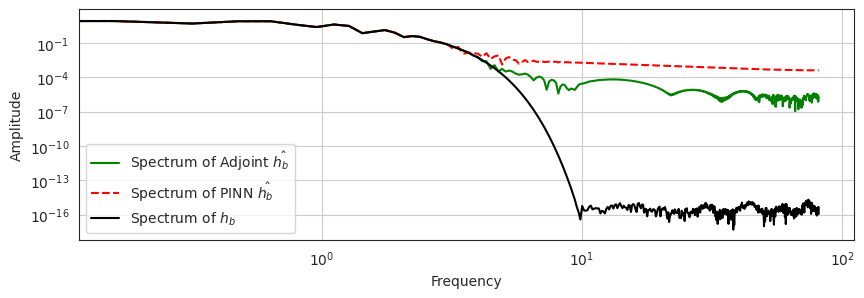

In [76]:
Nx = fpm.Nx
dx = grid.dx
# Compute Fourier Transform of hb
adj_hb_fft = np.fft.fft(adj[-1])
pinn_hb_fft = np.fft.fft(pinn[-1])
true_hb_fft = np.fft.fft(true_hb)

hb_freq = np.fft.fftfreq(Nx, d=dx)

# Take only the positive frequencies for plotting
adj_hb_amplitude = np.abs(adj_hb_fft[:Nx // 2])
pinn_hb_amplitude = np.abs(pinn_hb_fft[:Nx // 2])
true_hb_amplitude = np.abs(true_hb_fft[:Nx // 2])
hb_freq_positive = hb_freq[:Nx // 2]

# Plot the Fourier Amplitude Spectrum
plt.figure(figsize=(10, 3))
plt.loglog(hb_freq_positive,adj_hb_amplitude , color='green' , label = 'Spectrum of Adjoint $\hat{h_b}$')
plt.loglog(hb_freq_positive,pinn_hb_amplitude , color='red' ,linestyle = '--', label = 'Spectrum of PINN $\hat{h_b}$')
plt.loglog(hb_freq_positive,  true_hb_amplitude, color='black' ,alpha = 1 , label = 'Spectrum of $h_b$')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig(f'{param_path}/fft_hb')


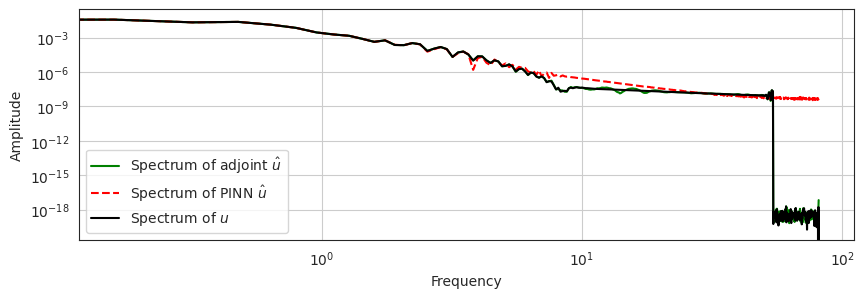

In [77]:
Nx = fpm.Nx
dx = grid.dx
# Compute Fourier Transform of hb
adj_u_fft = np.fft.fft(adj[0])
pinn_u_fft = np.fft.fft(pinn[0])
true_u_fft = np.fft.fft(ref[0])

h_freq = np.fft.fftfreq(Nx, d=dx)

# Take only the positive frequencies for plotting
adj_u_amplitude = np.abs(adj_u_fft[:Nx // 2])
pinn_u_amplitude = np.abs(pinn_u_fft[:Nx // 2])
true_u_amplitude = np.abs(true_u_fft[:Nx // 2])
h_freq_positive = h_freq[:Nx // 2]

# Plot the Fourier Amplitude Spectrum
plt.figure(figsize=(10, 3))
plt.loglog(h_freq_positive,adj_u_amplitude , color='green' , label = 'Spectrum of adjoint $\hat{u}$')
plt.loglog(h_freq_positive,pinn_u_amplitude , color='red' , linestyle = '--', label = 'Spectrum of PINN $\hat{u}$')
plt.loglog(h_freq_positive, true_u_amplitude, color='black' , alpha =1, label = 'Spectrum of $u$')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig(f'{param_path}/fft_u')